In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from multiprocessing import Pool
import numba as nb
#from tqdm.notebook import tqdm

# High-performance oriented programming habits
## The good
+ reuse and preallocate variables
+ precompute data when possible; access when needed
+ vectorize whenever possible (we will practice together)
+ think about complementary approaches (sometimes easier to compute)
+ check variable data types (even in Python); only start this if result OK
## The bad
+ nested for-loops
+ branching; especially in nested loops
+ dynamically changing array sizes
## The ugly
+ np.vectorize is a for-loop 'wrapper'
+ not profiling your code
+ asking for a GPU without knowing why
## Please note
+ me=lazy programmer
+ same as you, I'm still learning Python3
+ and slow at typing (no jokes please while actively coding in class :-))

In [2]:
sbox = np.array([
0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16
])
sbox.dtype

dtype('int64')

In [3]:
timings = np.loadtxt('timing_noisy.csv', delimiter=',')
timings.shape
plaintext = timings[:,range(16)]
# extra setup
times = timings[:,-1]
plaintext = plaintext.astype(np.int_)


# Attack Recipe from Slides
+ Note: n = number of samples; corresponds to rows of .csv
+ Attacker guesses a value K as key candidate for the key
    + Create two groups: group1 and group0
    + for i = 1 to n compute Sbox(firstbyte(p_i) XOR k) – this will be our ‘hypothesis’
    + If MSB of result is 1, the corresponding timing t_i goes to group1, otherwise to group0
    + On average, the timings of group1 should be higher than of group0
    + Averaging helps to get this information and reduce noise
    + The difference between averages of two groups is assigned guessed key byte k
    + This step needs to be repeated for all key candidates 𝐾 = 0 . . . 255
+ The highest difference between the averages shows the most probable value candidate for the key

In [5]:
delta = np.empty((plaintext.shape[1], 256), dtype=float)

full_keys = np.arange(256)
full_keys = full_keys.astype(np.int64)

times = np.reshape(times, (-1,1))

In [6]:
@nb.njit(fastmath=True)
def calculate_byte_parallel(plaintext, full_keys, sbox, times, delta):
    for byte in range(plaintext.shape[1]):
        xor_result = np.bitwise_xor(plaintext[:,byte].reshape(-1,1), full_keys)
        sbox_result = sbox.take(xor_result)
        # sbox_result = np.take(sbox, xor_result)
        
        arr = np.logical_and(np.right_shift(sbox_result, 7), 0x01)

        group1 = np.multiply(arr, times)
        group0 = np.subtract(times, group1)

        count_nonzero_group1 = np.count_nonzero(group1, axis=0)
        count_nonzero_group0 = np.count_nonzero(group0, axis=0)

        div1 = np.sum(group1, axis=0) / count_nonzero_group1
        div0 = np.sum(group0, axis=0) / count_nonzero_group0

        delta[byte] = np.subtract(div1, div0)
        

In [7]:
calculate_byte_parallel(plaintext, full_keys, sbox, times, delta)
# print(delta.shape, delta)

In [9]:
print("key:", np.argmax(delta, axis=1))

key: [ 41 142  79  30 183 104 193  19  15 246 189 223 236 119  47 176]


Samples vs. Value Plot


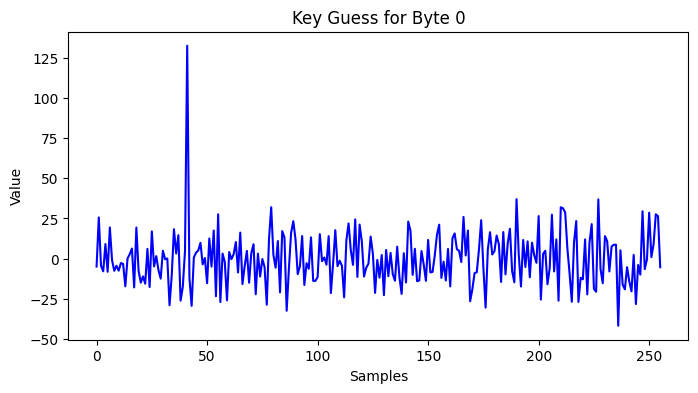

In [ ]:
b = 0
%matplotlib inline
print('Samples vs. Value Plot')
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(delta[b], 'blue')
ax.set_title("Key Guess for Byte "+ str(b))
ax.set_xlabel('Samples')
ax.set_ylabel('Value')
plt.show()
